In [48]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics


import dask
#dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
#from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Target time range
valid_start = np.datetime64('2019-06-01')
valid_end = np.datetime64('2019-09-30')

In [50]:
E = ed.EsioData.load()

# SIO Report Year_Month
cyear = '2019'
#cmonth = 'June'
cmonth = 'July'
cmonth = 'August'

month_cal=dict((v,k) for k,v in enumerate(calendar.month_abbr))
itstr = date_str = pd.to_datetime(datetime.datetime(int(cyear), month_cal[cmonth[0:3]], 1)).strftime('%Y-%m-%d')
itstr
r_yr_mon = cyear+'_'+cmonth
def_icefree = pd.to_datetime('2019-08-01').timetuple().tm_yday # doy that icefee even icefree at start
    # make it june 1 does not matter what year

print(itstr)
print(r_yr_mon)

2019-08-01
2019_August


In [70]:
def calc_IFD_10day(da, sic_threshold=0.5, DOY_s=1, time_dim='time', Nday=10, default_ice_free=None):
    ''' Calc the Ice Free Day (first) by Calender Year. 
    Returns day of year (doy) for each pixel when the sic value dropped below the sic_threshold 
    and stayed below that threshold for atleast Nday days.
    '''
    da = da.rename({time_dim:'time'})

    # Here we find pixels WITHOUT (<sic_threshold) Ice!!!
    sip_Xday = (da < sic_threshold).rolling(min_periods=1, center=False, time=Nday).sum().where(da.isel(time=0).notnull()) 

    # Now values range from 0 to Nday, keep only Nday pixel values, rescale them to 1 (end up with 0 with ice and 1 with ocean over past 10 days)
    sip_Xday_adj = sip_Xday.where(sip_Xday == Nday, other=0).where(da.isel(time=0).notnull())
    sip_Xday_adj = sip_Xday_adj.astype('float') / Nday

    # Now reduce over time dime, and find the first "1" value for each pixel (which is the last day of ice presence, with at least 10 days following ice free)
    ifd = sip_Xday_adj.reduce(np.argmax, dim='time') # Find index of first ice free
    #plt.figure()
    #ifd.plot()
    
    # Convert to Day of Year by adding the first time
    ifd = ifd + DOY_s - Nday - 1 # Add DOY_s and subtract the Nday window (rolling returns the right side label "trailing")
    #plt.figure()
    #ifd.plot()
    
    # Classify pixels 
    # 1) that were ice free at first index time to the default ice free date (i.e. June 1st)
    ifd = ifd.where(ifd > DOY_s, other=default_ice_free)
    #plt.figure()
    #ifd.plot()
    
    # 2) that never melted (perenial) to NaN
    # Grab last model time (end of Sept) and get mask of where ice is
    perenial_ice_mask = (da.min(dim='time') >= sic_threshold)
    ifd = ifd.where(~perenial_ice_mask, other=275)
    #plt.figure()
    #ifd.plot()
        
    # Apply Orig mask
    ifd = ifd.where(da.isel(time=0).notnull())    

    return ifd


In [71]:
c_vmin = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),  month_cal[cmonth[0:3]]  ,1)]][0]
c_vmax = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),10,1)]][0]
print(c_vmin, c_vmax)

213 274


In [72]:
# Get dates for plot
last_IFD = pd.to_datetime((np.datetime64('2019-01-01') + np.timedelta64(int(c_vmax),'D')))

In [73]:
# Get monthly ticks
DOY_months = [x.timetuple().tm_yday for x in pd.date_range(date_str,'2019-10-30', freq='MS')]
DOY_labels = [calendar.month_abbr[mn]+' 1' for mn in np.arange( month_cal[cmonth[0:3]]  ,last_IFD.month+1)]
assert len(DOY_months)==len(DOY_labels)

In [55]:
# compute climo10yr IFD
# BE SURE THESE ARE NON OVERLAPPING, MUST BE UPDATED FOR NEW DATA
# Get bootstrap and nrt observations with pole hole already filled in
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic
ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic

pred_year = int(cyear)
start_year = pred_year-1
ds_79=ds_79.sel(time=slice(str(start_year),str(pred_year-1)))  # end year just has to be way in the future
ds_81=ds_81.sel(time=slice('2015',str(pred_year-1)))  # restrict to before prediciton year, lower year not important

# Combine bootstrap with NASA NRT
ds_81 = ds_79.combine_first(ds_81)  # takes ds_79 as priority
ds_79 = None

year_all = [x.year for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':ds_81.time})
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds_81.time})
print(ds_81)

ObsYears=np.arange(min(2015, start_year), pred_year)
ObsYears

<xarray.DataArray 'sic' (time: 1461, y: 448, x: 304)>
dask.array<shape=(1461, 448, 304), dtype=float64, chunksize=(365, 448, 304)>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-12-31
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2018 2018 2018 2018 2018
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365


array([2015, 2016, 2017, 2018])

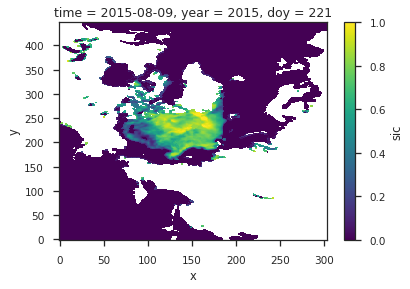

In [56]:
ds_81.isel(time=220).plot()

Looking for times between 2015-08-01T00:00:00.000000 and 2015-10-01T00:00:00.000000


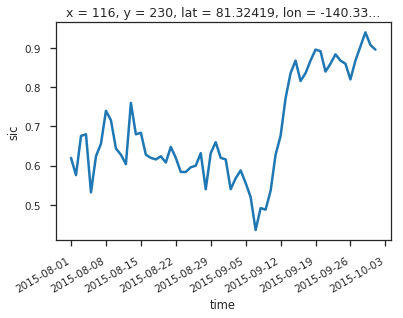

In [101]:
y=2015
tmpo=ds_81.sel(time=str(y))
first_day = np.datetime64(datetime.datetime(int(y),8,1))
last_day = np.datetime64(datetime.datetime(int(y),10,1))
print("Looking for times between",first_day,"and",last_day)

tmpo = tmpo.sel(time=slice(first_day,last_day))
#tmpo=tmpo.isel(y=200,x=150)  # a nice curve to test
#tmpo=tmpo.isel(y=250,x=150)  # never below 0.5
#tmpo=tmpo.isel(y=100,x=100)  # all open water
tmpo=tmpo.isel(y=230,x=116)  # just a couple days below 0.5
tmpo.plot()

In [103]:
DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([tmpo.time.min().values])]
print(DOY_first_vt)

# setting the default_ice_free value equal to c_vmin is important
ifd = calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='time', 
                                Nday=10, default_ice_free=def_icefree)

print(ifd.values)
print(tmpo.time[int(ifd)-DOY_first_vt[0]-1])

[213]
213.0
<xarray.DataArray 'time' ()>
array('2015-10-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-10-01
    x        int64 116
    y        int64 230
    lat      float64 81.32
    lon      float64 -140.3
    xm       int64 -950000
    ym       int64 100000
    year     int64 2015
    doy      int64 274


<xarray.Dataset>
Dimensions:    (time: 61, xaxis: 448, yaxis: 304)
Coordinates:
  * time       (time) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
Dimensions without coordinates: xaxis, yaxis
Data variables:
    latitude   (xaxis, yaxis) float32 ...
    longitude  (xaxis, yaxis) float32 ...
    areacello  (xaxis, yaxis) float32 ...
    sftof      (xaxis, yaxis) uint8 ...
    siconc     (time, xaxis, yaxis) uint8 ...
Attributes:
    description:  NicoSun_SIPN_August_forecast_Mean


array([102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102], dtype=uint8)

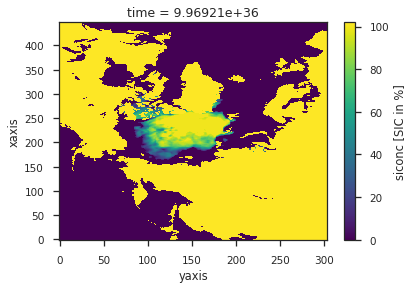

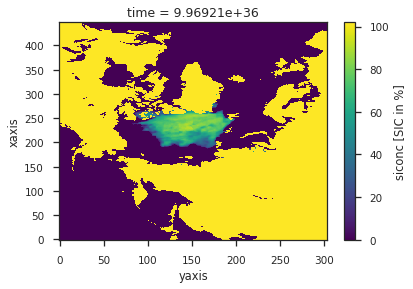

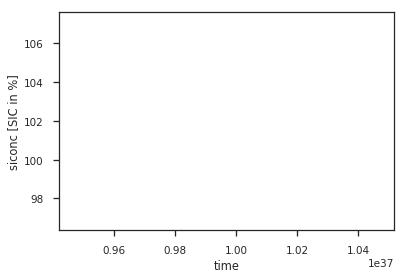

In [144]:
sip_f = '/home/disk/sipn/upload/nicosipn/forecast/2019_08/NicoSun_2019_002_concentration.nc'
NMAX = 122

ds_user = xr.open_dataset(sip_f)
ds_user = ds_user.isel(time=range(61,NMAX))

print(ds_user)
ds_user.siconc.isel(time=1).plot()
plt.figure()
ds_user.siconc.isel(time=45).plot()
plt.figure()

tmpo=ds_user.siconc

tmpo=tmpo.isel(yaxis=165,xaxis=130)  # a nice curve to test
#tmpo=tmpo.isel(yaxis=250,xaxis=150)  # never below 0.5
#tmpo=tmpo.isel(yaxis=100,xaxis=100)  # all open water
#tmpo=tmpo.isel(yaxis=230,xaxis=116)  # just a couple days below 0.5
tmpo.plot()
tmpo.values

vt_vec is  61
<xarray.DataArray 'sic' (init_time: 1, fore_time: 61, y: 448, x: 304)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
    init_date   (init_time) datetime64[ns] 2019-08-01
    valid_time  (fore_time) datetime64[ns] 2019-08-01 2019-08-02 ... 2019-09-30
Dimensions without coordinates: init_time, fore_time, y, x


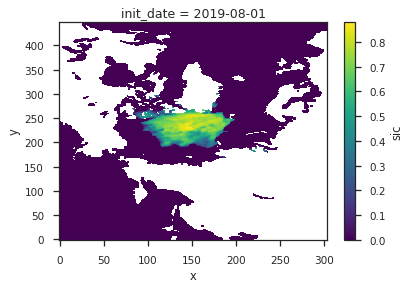

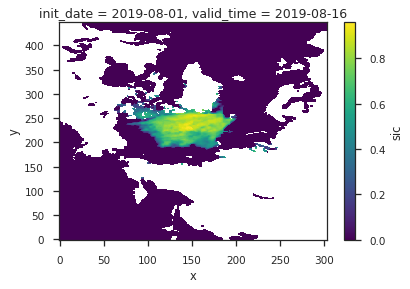

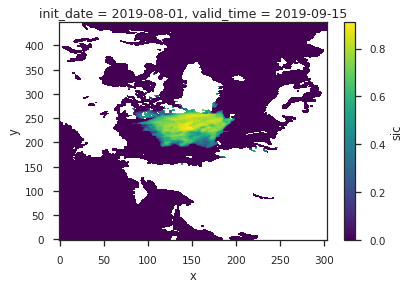

In [135]:


theland = ds_user.sftof  # nico land mask        
ds_user = ds_user.siconc
ds_user = ds_user.where(theland<50, other=np.nan)

da = xr.DataArray(ds_user.values/100,dims=['fore_time','y','x'])
da=da.expand_dims('init_time')
da.name = 'sic'    
da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]),dims='init_time')

vt_vec = np.arange(datetime.datetime(2019,8,1),datetime.datetime(2019,10,1),datetime.timedelta(days=1)).astype('datetime64[ns]')

print('vt_vec is ',len(vt_vec))
da.coords['valid_time'] = xr.DataArray(vt_vec,dims='fore_time')

ds_model = da
da = None
ds_model.load()
    
DOY_first_vt = def_icefree = 213

ds_model.min(dim='fore_time').plot()
plt.figure()
ds_model.isel(fore_time=15).plot()
plt.figure()
ds_model.isel(fore_time=45).plot()


print(ds_model)

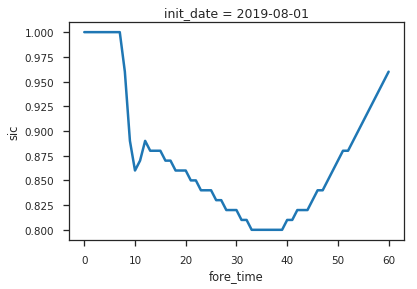

In [145]:
tmpo=ds_model
#tmpo=tmpo.isel(y=200,x=150)  # a nice curve to test
tmpo=tmpo.isel(y=250,x=150)  # never below 0.5
#tmpo=tmpo.isel(y=100,x=100)  # all open water
#tmpo=tmpo.isel(y=230,x=116)  # just a couple days below 0.5
tmpo.plot()

In [146]:
#    ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
ds_ifd = calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt, time_dim='fore_time', 
                                Nday=10, default_ice_free=def_icefree)
print(ds_ifd.values-212)

[63.]


In [60]:
da = tmpo
sic_threshold=0.5
DOY_s=DOY_first_vt[0] 
time_dim='time'
Nday=10 
default_ice_free=def_icefree
print(DOY_s,def_icefree)
da = da.rename({time_dim:'time'})
print('da = ',da.values)

213 213
da =  [0.812 0.8   0.98  0.84    nan 0.784 0.86  0.748 0.724 0.8   0.796 0.772
 0.96  0.992 0.96  0.856 0.76  0.74  0.82  0.884 0.848 0.956 0.936 0.932
 0.944 0.992 0.984 0.952 0.972 0.992 1.    0.996 0.992 0.964 0.94  0.9
 0.844 0.832 0.856 0.876 0.904 0.852 0.852 0.844 0.88  0.876 0.856 0.86
 0.868 0.868 0.944 0.924 0.932 0.9   0.9   0.916 0.896 0.832 0.848 0.868
 0.86  0.828]


In [61]:
# Here we find pixels WITHOUT (<sic_threshold) Ice!!!
sip_Xday = (da < sic_threshold)
print('sip_Xday I) ',sip_Xday.values)

sip_Xday = (da < sic_threshold).rolling(min_periods=1, center=False, time=Nday).sum()
print('sip_Xday II) ',sip_Xday.values)

sip_Xday = (da < sic_threshold).rolling(min_periods=1, center=False, time=Nday).sum().where(da.isel(time=0).notnull()) 


sip_Xday I)  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
sip_Xday II)  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [69]:
# Now values range from 0 to Nday, keep only Nday pixel values, rescale them to 1 (end up with 0 with ice and 1 with ocean over past 10 days)
sip_Xday_adj = sip_Xday.where(sip_Xday == Nday, other=0).where(da.isel(time=0).notnull())
sip_Xday_adj = sip_Xday_adj.astype('float') / Nday
print('sip_Xday.adj) ',sip_Xday_adj.values)


# Now reduce over time dime, and find the first "1" value for each pixel (which is the last day of ice presence, with at least 10 days following ice free)
ifd = sip_Xday_adj.reduce(np.argmax, dim='time') # Find index of first ice free
print('ifd 0: ',ifd.values)


# Convert to Day of Year by adding the first time
ifd = ifd + DOY_s - Nday - 1 # Add DOY_s and subtract the Nday window (rolling returns the right side label "trailing")
print('ifd I: ',ifd.values)


# Classify pixels 
# 1) that were ice free at first index time to the default ice free date (i.e. June 1st)
ifd = ifd.where(ifd > DOY_s, other=default_ice_free)
print('ifd II: ',ifd.values)

# 2) that never melted (perenial) to NaN
# Grab last model time (end of Sept) and get mask of where ice is
perenial_ice_mask = (da.min(dim='time') >= sic_threshold)

print(perenial_ice_mask.values)

ifd = ifd.where(~perenial_ice_mask, other=275)
print('ifd III: ',ifd.values)


# Apply Orig mask
ifd = ifd.where(da.isel(time=0).notnull())    

sip_Xday.adj)  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ifd 0:  0
ifd I:  202
ifd II:  213
True
ifd III:  275
